# OSIC EDA
**Welcome Dr. OldYen Join this competition !!!**<br> Following is my EDA after read some EDA thread like:<br>
[OSIC Pulmonary Fibrosis Progression: Basic EDA](https://www.kaggle.com/piantic/osic-pulmonary-fibrosis-progression-basic-eda)<br>
[Pulmonary Fibrosis Competition: EDA & DICOM Prep](https://www.kaggle.com/andradaolteanu/pulmonary-fibrosis-competition-eda-dicom-prep)<br>
[OSIC Pulmonary Fibrosis Progression - EDA](https://www.kaggle.com/gunesevitan/osic-pulmonary-fibrosis-progression-eda)<br>
<br>
So far the most of kagglers build model base on tabular data only, like:<br>
[EfficientNets + Quantile Regression (Inference)](https://www.kaggle.com/khoongweihao/efficientnets-quantile-regression-inference)
<br>
<br>
But there is a few example to use end-to-end model to combine CT scans & tabular data, like:<br>
[End-to-end model: CT scans + Tabular](https://www.kaggle.com/carlossouza/end-to-end-model-ct-scans-tabular)<br>

So I think the keypoint of this competition is:<br>
1. to combine image&tabular data properly
2. eliminate the outlier
3. predict randomness of FVC comes from measurement/personal issue/etc... correctly.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf

from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import keras.backend as K

import matplotlib.pyplot as plt
from scipy import stats
# !pip install sklearn

# Loading dataset

In [2]:
import pathlib
train_df = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv')
test_df = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv')
submit_df = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/sample_submission.csv')

# Explore Data

there are 176 patients in training/test/submission dataset and each patient has different observed time range.
i'm trying to figure out the coverage of training data since the goal is to estimate FVC weekly in 2.5 years from CT scan.

In [3]:
# pick one patient with data more the 1 yr
train_df[train_df['Patient']==train_df['Patient'][9]]

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
9,ID00009637202177434476278,8,3660,85.282878,69,Male,Ex-smoker
10,ID00009637202177434476278,9,3610,84.117812,69,Male,Ex-smoker
11,ID00009637202177434476278,11,3895,90.758691,69,Male,Ex-smoker
12,ID00009637202177434476278,13,3759,87.589710,69,Male,Ex-smoker
13,ID00009637202177434476278,15,3639,84.793550,69,Male,Ex-smoker
14,ID00009637202177434476278,22,3578,83.372169,69,Male,Ex-smoker
15,ID00009637202177434476278,33,3625,84.467332,69,Male,Ex-smoker
16,ID00009637202177434476278,45,3390,78.991518,69,Male,Ex-smoker
17,ID00009637202177434476278,60,3214,74.890484,69,Male,Ex-smoker


In [4]:
# Patient#
print("Patient# = "+str(len(train_df['Patient'].unique())))

Patient# = 176


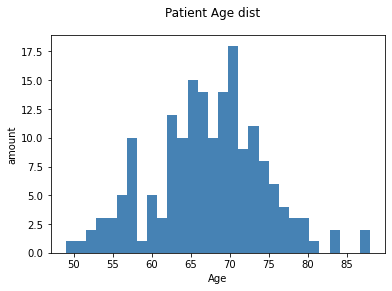

In [13]:
# Patient Age dist
plt.suptitle('Patient Age dist')
group = train_df.groupby('Patient')
df2 = pd.DataFrame({'Patient':train_df.Patient.unique()})
df2['Age'] = [list(set(train_df['Age'].loc[train_df['Patient'] == x['Patient']]))[0] 
    for _, x in df2.iterrows()]
plt.hist(df2["Age"], bins=30, histtype='stepfilled', color='steelblue', edgecolor='none')
plt.xlabel("Age")
plt.ylabel("amount")
plt.show()

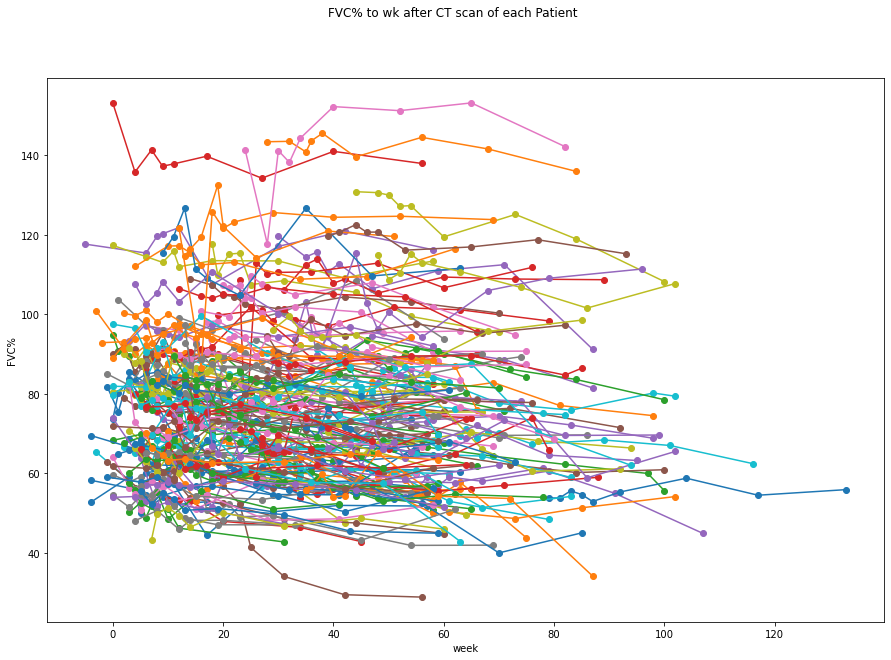

In [26]:
plt.figure(figsize=(15,10))
xs = np.arange(-5,134,1)
start_fvc_p=[]
start_week=[]
slope_all_p=[]
slope_std_p=[]
slope_p_value_p=[]
slope_intercept_p=[]
slope_age=[]
slope_sex=[]
slope_smoke=[]

plt.suptitle('FVC% to wk after CT scan of each Patient')
for i in train_df['Patient'].unique():
#     for idx, wk, fvc in enumerate(train_df[['Weeks','FVC']]):
    ridx=-1
    y=[None]*len(xs)
    df_tmp = train_df[train_df['Patient']==i]
    x_reg=[]
    y_reg=[]
    age=0
    smoke=""
    sex=""
    y_ctl=0
    for cidx, row in df_tmp.iterrows():
        y_ctl+=1
        if y_ctl==1:
            start_fvc_p.append(row["Percent"])
            start_week.append(row["Weeks"])
        y[row["Weeks"]+5]=row["Percent"]
        x_reg.append(row["Weeks"])
        y_reg.append(row["Percent"])
        age=row["Age"]
        smoke=row["SmokingStatus"]
        sex=row["Sex"]
    ### plot all FVC curve
    series1 = np.array(y).astype(np.double)
    s1mask = np.isfinite(series1)
    plt.plot(xs[s1mask], series1[s1mask], linestyle='-', marker='o')
    
    #### get regression line info
    
    x_reg_int = list(map(int, x_reg))
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_reg_int,y_reg)
    slope_all_p.append(slope)
    slope_std_p.append(std_err)
    slope_p_value_p.append(p_value)
    slope_intercept_p.append(intercept)
    slope_age.append(age)
    slope_sex.append(sex)
    slope_smoke.append(smoke)
    line = []
    for ii in x_reg_int:
        line.append((slope*ii)+intercept)
#     plt.plot(x_reg, line, 'r', label='y={:.2f}x+{:.2f}'.format(slope,intercept))

    #### end
plt.xlabel("week")
plt.ylabel("FVC%")
plt.show()

# s1mask = np.isfinite(series1)
# series2 = np.array([2, None, 5, None, 4, None, 3, 2]).astype(np.double)
# s2mask = np.isfinite(series2)

# plt.plot(xs[s1mask], series1[s1mask], linestyle='-', marker='o')
# plt.plot(xs[s2mask], series2[s2mask], linestyle='-', marker='o')

# plt.show()

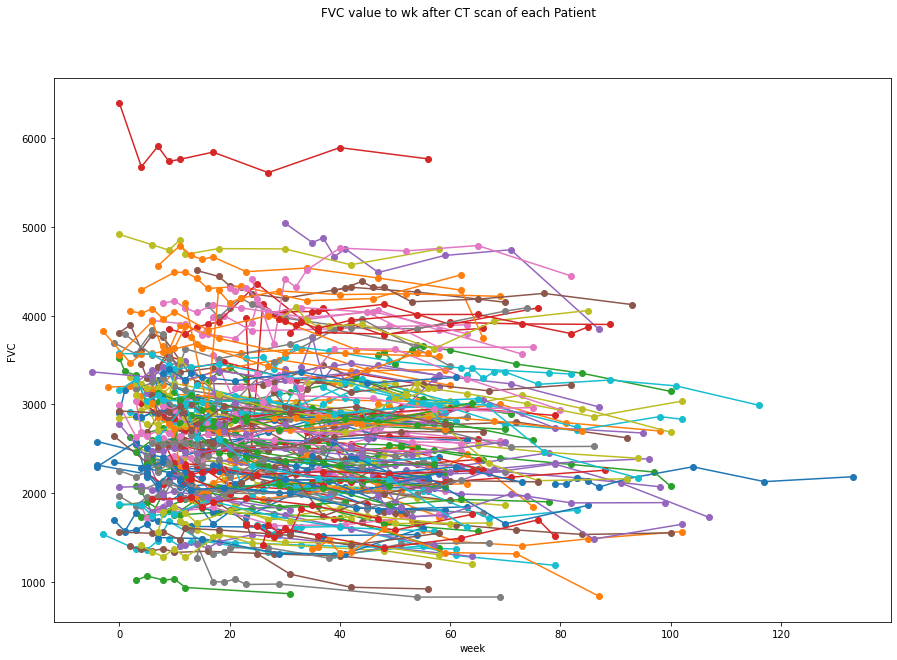

In [14]:

plt.figure(figsize=(15,10))
plt.suptitle('FVC value to wk after CT scan of each Patient')
xs = np.arange(-5,134,1)
start_fvc=[]
start_week=[]
slope_all=[]
slope_std=[]
slope_p_value=[]
slope_intercept=[]
for i in train_df['Patient'].unique():
#     for idx, wk, fvc in enumerate(train_df[['Weeks','FVC']]):
    ridx=-1
    y=[None]*len(xs)
    df_tmp = train_df[train_df['Patient']==i]
    x_reg=[]
    y_reg=[]
    age=0
    y_ctl=0
    for cidx, row in df_tmp.iterrows():
        y_ctl+=1
        if y_ctl==1:
            start_fvc.append(row["FVC"])
            start_week.append(row["Weeks"])
        y[row["Weeks"]+5]=row["FVC"]
        x_reg.append(row["Weeks"])
        y_reg.append(row["FVC"])
        age=row["Age"]
    ### plot all FVC curve
    series1 = np.array(y).astype(np.double)
    s1mask = np.isfinite(series1)
    plt.plot(xs[s1mask], series1[s1mask], linestyle='-', marker='o')
    
    #### get regression line info
    
    x_reg_int = list(map(int, x_reg))
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_reg_int,y_reg)
    slope_all.append(slope)
    slope_std.append(std_err)
    slope_p_value.append(p_value)
    slope_intercept.append(intercept)
    line = []
    for ii in x_reg_int:
        line.append((slope*ii)+intercept)
#     plt.plot(x_reg, line, 'r', label='y={:.2f}x+{:.2f}'.format(slope,intercept))

    #### end

plt.xlabel("week")
plt.ylabel("FVC")
plt.show()

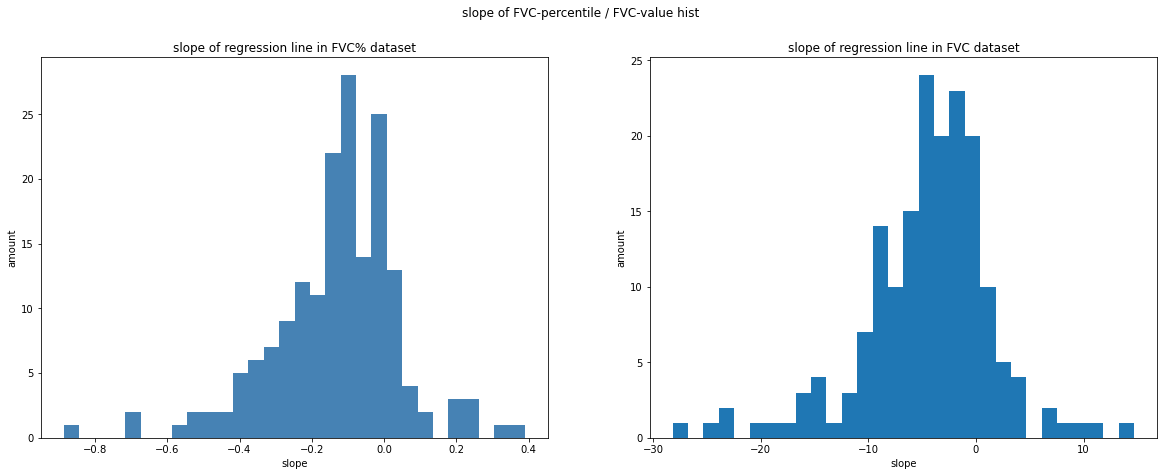

In [28]:
# print(slope_all)
fig, (ax1, ax2)  = plt.subplots(1,2,figsize=(20,7))
fig.suptitle('slope of FVC-percentile / FVC-value hist')
ax1.hist(slope_all_p, bins=30,histtype='stepfilled', color='steelblue', edgecolor='none')
ax2.hist(slope_all, bins=30)
ax1.set_title("slope of regression line in FVC% dataset")
ax2.set_title("slope of regression line in FVC dataset")
plt.setp(ax1, xlabel='slope')
plt.setp(ax1, ylabel='amount')
plt.setp(ax2, xlabel='slope')
plt.setp(ax2, ylabel='amount')
plt.show()

# Any correlation between slope of FVC% regression line and age/sex/smoke status?

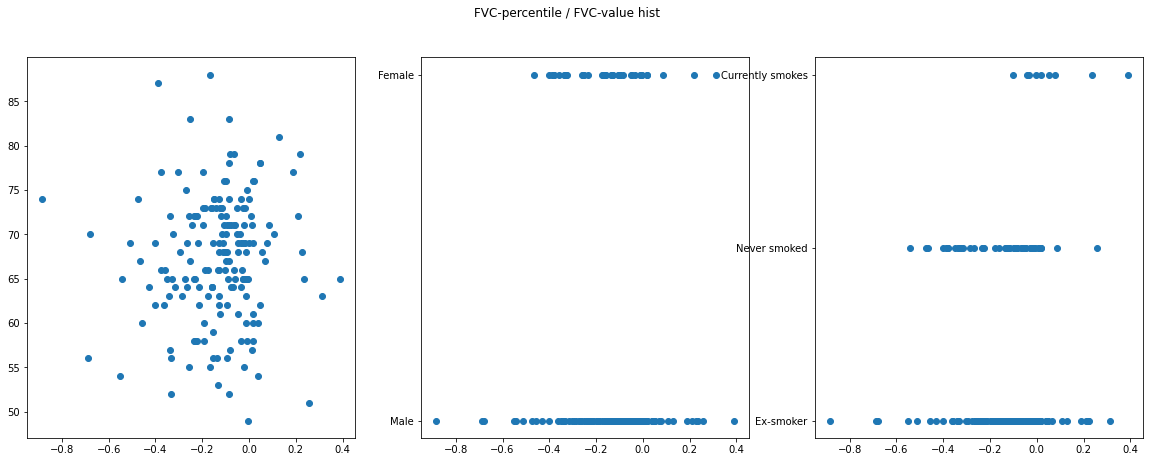

In [29]:
# len(slope_smoke)
fig, (ax1,ax2,ax3)  = plt.subplots(1,3,figsize=(20,7))
fig.suptitle('FVC-percentile / FVC-value hist')
ax1.scatter(slope_all_p ,slope_age)
ax2.scatter(slope_all_p ,slope_sex)
ax3.scatter(slope_all_p ,slope_smoke)
plt.show()

# Is FVC% effect the slope?

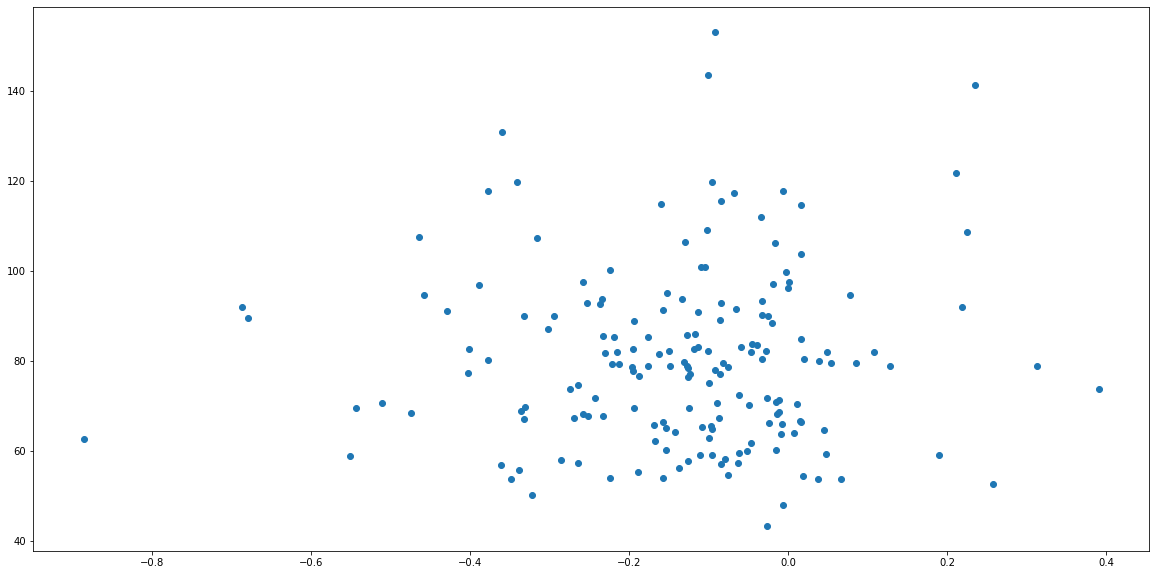

In [30]:
plt.figure(figsize=(20,10))
# plt.scatter(slope_all,slope_p_value)
# plt.show()
ax = plt.gca()
ax.scatter(slope_all_p ,start_fvc_p)
# ax.set_yscale('log')
plt.show()

# Is week# after CT scan correlated with FVC value?

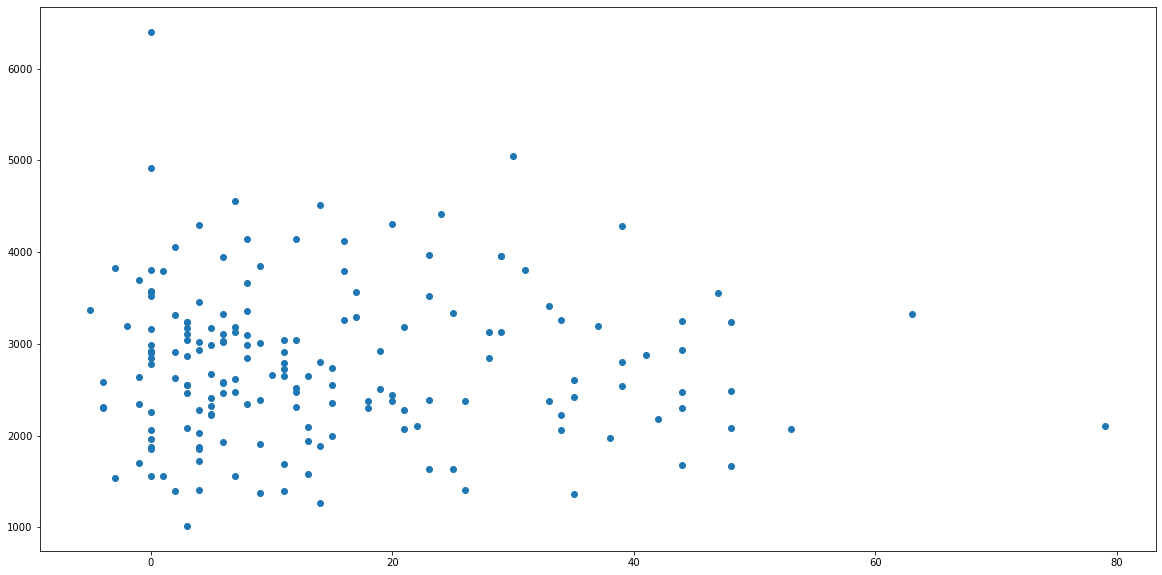

In [31]:
# print(slope_age)
plt.figure(figsize=(20,10))
plt.scatter(start_week,start_fvc)
plt.show()

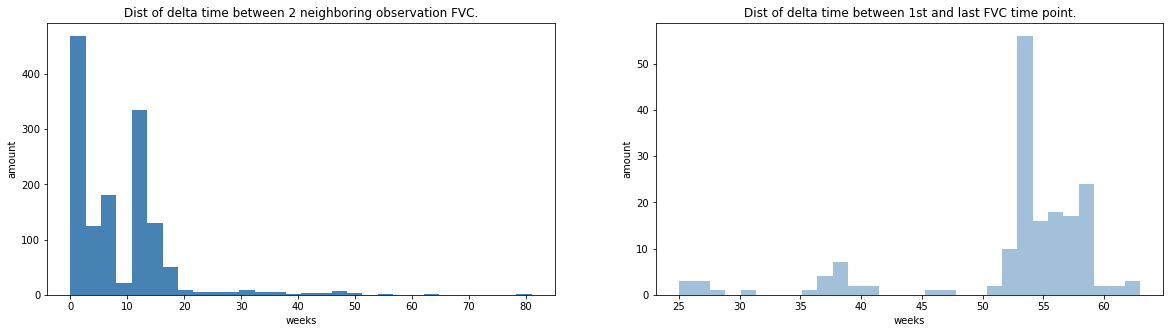

In [44]:
# find point average time-diff & patientwise training data time range
time_diff_all=[]
case_range=[]
case_id=[]
for i in train_df['Patient'].unique():
    
    df_tmp = train_df[train_df['Patient']==i].sort_values(['Weeks'], ascending=[1]) #.sort_index(by = 'Weeks')
    case_0=0
    case_len=0
    case_tmp=0
    y_ctl=0
    for cidx, row in df_tmp.iterrows():
        y_ctl+=1
        if y_ctl==1:
            case_0=row["Weeks"]
        else:
            time_diff_all.append((row["Weeks"]-case_tmp))
            case_len=row["Weeks"]-case_0
            case_tmp=row["Weeks"]
    case_range.append(case_len)
    case_id.append([i,case_len])
# print(case_id)
    
fig, (ax1, ax2)  = plt.subplots(1,2,figsize=(20,5))
# fig.suptitle('FVC-percentile / FVC-value hist')
ax1.hist(time_diff_all, bins=30, histtype='stepfilled', color='steelblue', edgecolor='none')
ax2.hist(case_range, bins=30, alpha=0.5, histtype='stepfilled', color='steelblue', edgecolor='none')

ax1.set_title("Dist of delta time between 2 neighboring observation FVC.")
ax2.set_title("Dist of delta time between 1st and last FVC time point.")
plt.setp(ax1, xlabel='weeks')
plt.setp(ax1, ylabel='amount')
plt.setp(ax2, xlabel='weeks')
plt.setp(ax2, ylabel='amount')
plt.show()


plt.show()

In [36]:
# dict(train_df)
# submit_df.head()
# submit_df['Patient']=submit_df['Patient_Week'].str.split("_")[0]
# submit_df['Weeks']=int(submit_df['Patient_Week'].str.split("_")[1])
submit_df['Weeks']=0
submit_df[['Patient','Weeks']] = submit_df['Patient_Week'].str.split('_',expand=True)
submit_df['Weeks'] = submit_df['Weeks'].astype(int)
# print(submit_df['Patient_Week'][1])
# for idx, i in enumerate(submit_df['Patient_Week']):
#     i_tmp=i.split("_")
#     submit_df['Patient'][i]=i_tmp[0]
#     submit_df['Patient'][i]=i_tmp[0]
submit_df.head()

,Patient_Week,FVC,Confidence,Weeks,Patient
0,ID00419637202311204720264_-12,2000,100,-12,ID00419637202311204720264
1,ID00421637202311550012437_-12,2000,100,-12,ID00421637202311550012437
2,ID00422637202311677017371_-12,2000,100,-12,ID00422637202311677017371
3,ID00423637202312137826377_-12,2000,100,-12,ID00423637202312137826377
4,ID00426637202313170790466_-12,2000,100,-12,ID00426637202313170790466


# List the target patients

In [37]:
submit_df['Patient'].unique()

array(['ID00419637202311204720264', 'ID00421637202311550012437',
       'ID00422637202311677017371', 'ID00423637202312137826377',
       'ID00426637202313170790466'], dtype=object)

In [38]:
train_df[train_df["Patient"]=="ID00010637202177584971671"]

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
18,ID00010637202177584971671,0,3523,94.724672,60,Male,Ex-smoker
19,ID00010637202177584971671,1,3373,90.691547,60,Male,Ex-smoker
20,ID00010637202177584971671,3,3327,89.454721,60,Male,Ex-smoker
21,ID00010637202177584971671,5,2993,80.474296,60,Male,Ex-smoker
22,ID00010637202177584971671,7,3030,81.469133,60,Male,Ex-smoker
23,ID00010637202177584971671,13,3103,83.431921,60,Male,Ex-smoker
24,ID00010637202177584971671,25,2993,80.474296,60,Male,Ex-smoker
25,ID00010637202177584971671,37,2474,66.519682,60,Male,Ex-smoker
26,ID00010637202177584971671,54,2518,67.702732,60,Male,Ex-smoker


In [39]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('target')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

In [40]:
import seaborn as sns
# import matplot
# train_df["Weeks"].displot()
# sns.distplot(list(train_df["Weeks"]))
train_df[train_df["Weeks"]==1].count()["Weeks"]

5

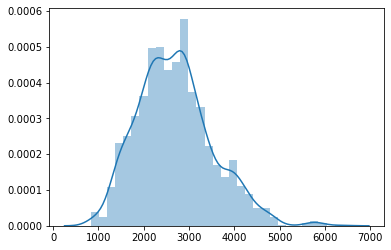

In [45]:
# train_df.describe()
sns.distplot(list(train_df["FVC"]))
plt.show()